In [ ]:
!pip install -U portalocker>=2.0.0

## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import csv

In [ ]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 117588123.10it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6569807.49it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 62857375.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7425129.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

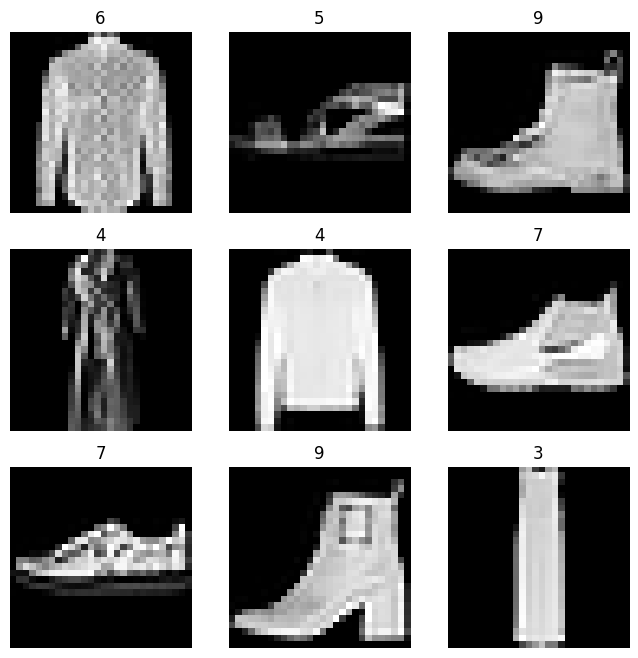

In [ ]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self, layer_sizes): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, layer_sizes[0]) ## First fully connected linear layer, 28*28 input features

        # Dynamically add hidden layers based on the layer_sizes list
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.hidden_layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

        # Output layer
        self.fc_output = nn.Linear(layer_sizes[-1], 10)  ## 10 output features because MNIST has 10 target classes

    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28) #the array is sent in as a vector
        x = torch.relu(self.fc1(x)) ## Changed relu activation for the first layer
        # Apply activation to additional hidden layers
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x)) ## Applying tanh activation
        x = self.fc_output(x) ## no modifications to the activation of the output layer
        return x

# Initializing the neural network
# model = MLP()

In [ ]:
# CSV file to write results
with open('experiment_results.csv', mode='w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Layer Configuration', 'Optimizer', 'Batch Size', 'Learning Rate', 'Momentum', 'Weight Decay', 'Accuracy'])
  # writer.writerow(['Layer Configuration', 'Optimizer', 'Batch Size', 'Learning Rate', 'Accuracy'])  # 1st run

parameters = {
# 1st run
# 'layer_configurations' : [
#   # Two hidden layers, incrementing the first layer by 30 and the second by 10
#   [32, 16], [62, 26], [92, 36], [122, 46],
#   # Three hidden layers
#   [30, 20, 10], [60, 40, 20]
# ],

'layer_configurations' : [[92, 36]],

'optimizers': {
  optim.SGD: [
    {'lr': 0.01, 'momentum': 0.9},
    {'lr': 0.005, 'momentum': 0.9},
    {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4}
  ],
  optim.Adam: [
    {'lr': 0.001},
    {'lr': 0.0005},
    {'lr': 0.001, 'weight_decay': 1e-4}
  ],
}
}

In [ ]:
trained_models = {}
# default_optimizer_cls = optim.Adam  # Choosing Adam as the default optimizer
# default_opt_config = {'lr': 0.001}  # Default learning rate

for layer_config in parameters['layer_configurations']:
    for optimizer_cls, optimizer_configs in parameters['optimizers'].items():
        for opt_config in optimizer_configs:
          # Check if the optimizer configuration has 'weight_decay' and if not, add the default value
          opt_config = {**opt_config, 'weight_decay': opt_config.get('weight_decay', 0)}

          # Initialize the model with the current configuration
          model = MLP(layer_config)

          # Loss function and optimizer
          criterion = nn.CrossEntropyLoss()
          # optimizer = default_optimizer_cls(model.parameters(), **default_opt_config) # 1st run

          # Initialize the optimizer with the parameters
          optimizer = optimizer_cls(model.parameters(), **opt_config)

          # # Print the configuration of 1st run
          # print(f"Training with layer configuration: {layer_config}, using default optimizer: {default_optimizer_cls.__name__}, params: {default_opt_config}")

          # Print the configuration of 2rd run
          print(f"Training with layer configuration: {layer_config}, optimizer: {optimizer_cls.__name__}, params: {opt_config}, batch size: {64}")

          # Training the neural network
          num_epochs = 32
          for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
              inputs, labels = data
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
              if i % 100 == 99:  # print every 100 mini-batches
                  print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                  running_loss = 0.0

            # Update trained_models dictionary
            model_key = (str(layer_config), optimizer_cls.__name__, str(opt_config['lr']), str(opt_config.get('momentum', '')), str(opt_config.get('weight_decay', '')))
            # model_key = (str(layer_config), default_optimizer_cls.__name__, str(default_opt_config['lr']))   #1st run
            trained_models[model_key] = model
          print('Finished Training')

Training with layer configuration: [92, 36], optimizer: SGD, params: {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0}, batch size: 64
Epoch 1, Batch 100, Loss: 1.2471020644903184
Epoch 1, Batch 200, Loss: 0.6583910703659057
Epoch 1, Batch 300, Loss: 0.5700451430678367
Epoch 1, Batch 400, Loss: 0.5151888445019722
Epoch 1, Batch 500, Loss: 0.48955649614334107
Epoch 1, Batch 600, Loss: 0.4848267425596714
Epoch 1, Batch 700, Loss: 0.4593894663453102
Epoch 1, Batch 800, Loss: 0.46658528596162796
Epoch 1, Batch 900, Loss: 0.4456717935204506
Epoch 2, Batch 100, Loss: 0.4377768735587597
Epoch 2, Batch 200, Loss: 0.42499431654810904
Epoch 2, Batch 300, Loss: 0.41194877222180365
Epoch 2, Batch 400, Loss: 0.3863137577474117
Epoch 2, Batch 500, Loss: 0.39459278106689455
Epoch 2, Batch 600, Loss: 0.39556963205337525
Epoch 2, Batch 700, Loss: 0.3863236691057682
Epoch 2, Batch 800, Loss: 0.3679627698659897
Epoch 2, Batch 900, Loss: 0.3909236279129982
Epoch 3, Batch 100, Loss: 0.37693637624382975
Epoc

In [ ]:
# Open the CSV file in append mode to write the evaluation results
with open('experiment_results.csv', mode='a', newline='') as file:
  writer = csv.writer(file)

  for model_key, model in trained_models.items():
    # Unpack model_key to get the configuration details
    layers_config, optimizer_name, lr, momentum, weight_decay = model_key
    # layers_config, optimizer_name, lr = model_key  # 1st run

    # Evaluating the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print(f'Accuracy on test set: { correct / total}%')
    accuracy = correct / total
    print(f'Accuracy of config {layers_config} with {optimizer_name}, lr={lr}, momentum={momentum}, weight_decay={weight_decay} on test set: {accuracy:.2%}')
    # print(f'Accuracy of config {layers_config} with {optimizer_name}, lr={lr} on test set: {accuracy:.2%}') # 1st run

    # Append to the CSV file
    writer.writerow([
      str(layers_config),
      optimizer_name,
      '64',
      lr,
      momentum or 'N/A',
      weight_decay or '0',
      f'{accuracy:.2%}'
  ])

Accuracy of config [92, 36] with SGD, lr=0.01, momentum=0.9, weight_decay=0 on test set: 88.15%
Accuracy of config [92, 36] with SGD, lr=0.005, momentum=0.9, weight_decay=0 on test set: 88.02%
Accuracy of config [92, 36] with SGD, lr=0.01, momentum=0.9, weight_decay=0.0001 on test set: 88.57%
Accuracy of config [92, 36] with Adam, lr=0.001, momentum=, weight_decay=0 on test set: 88.22%
Accuracy of config [92, 36] with Adam, lr=0.0005, momentum=, weight_decay=0 on test set: 88.56%
Accuracy of config [92, 36] with Adam, lr=0.001, momentum=, weight_decay=0.0001 on test set: 88.30%


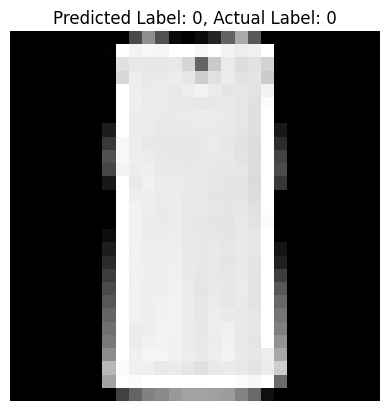

In [ ]:
model_key = ('[92, 36]', 'SGD', '0.01', '0.9', '0.0001')
model = trained_models.get(model_key)  # Retrieve the model

image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation fucntion:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## CNN Implimentation with Keras

In [ ]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import legacy, SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

import csv

In [ ]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [ ]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
parameters = {
    'layer_configurations': [
      # Base configuration
      [Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Increase Conv2D filters
      [Conv2D(64, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Add Dropout layer
      [Conv2D(32, (3, 3), activation='relu'), Dropout(0.25), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Change kernel size
      [Conv2D(32, (5, 5), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Add another Dense layer
      [Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(64, activation='relu'), Dense(10, activation='softmax')],
      # Increase Dense units
      [Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(256, activation='relu'), Dense(10, activation='softmax')],
      # Use tanh activation in Conv2D
      [Conv2D(32, (3, 3), activation='tanh'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Add a second Conv2D layer with more filters
      [Conv2D(32, (3, 3), activation='relu'), Conv2D(64, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Increase MaxPooling size
      [Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((3, 3)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Combine Dropout with increased filters in Conv2D
      [Conv2D(64, (3, 3), activation='relu'), Dropout(0.3), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
      # Double Conv2D layers before pooling
      [Conv2D(32, (3, 3), activation='relu'), Conv2D(32, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Flatten(), Dense(128, activation='relu'), Dense(10, activation='softmax')],
    ],

    'batch_sizes': [32, 64, 128, 256, 512],

    'optimizers': {
      'adam': [
        {'learning_rate': 0.001},  # Base learning rate
        {'learning_rate': 0.0005, 'decay': 1e-6},  # Slightly lower learning rate with a small decay
        {'learning_rate': 0.0001, 'decay': 1e-5},  # Much lower learning rate with higher decay
        {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999},  # Using default decay but tweaking beta parameters
        {'learning_rate': 0.002, 'decay': 1e-4}  # Higher learning rate with decay
    ],
      'sgd': [
        {'learning_rate': 0.01, 'momentum': 0.9},  # High learning rate with high momentum
        {'learning_rate': 0.01, 'momentum': 0.9, 'decay': 1e-6},  # High learning rate and momentum with decay
        {'learning_rate': 0.005, 'momentum': 0.8},  # Lower learning rate with slightly lower momentum
        {'learning_rate': 0.02, 'momentum': 0.9},  # Higher learning rate with high momentum
    ],
      'rmsprop': [
        {'learning_rate': 0.0005, 'decay': 1e-5},  # Lower learning rate with higher decay
        {'learning_rate': 0.001, 'rho': 0.9},  # Default learning rate, adjust rho (discounting factor for the gradient)
    ]
    }
}

# Function to create optimizer instance
def get_optimizer(name, params):
    if name.lower() == 'adam':
        return legacy.Adam(**params)
    elif name.lower() == 'sgd':
        return legacy.SGD(**params)
    elif name.lower() == 'rmsprop':
        return legacy.RMSprop(**params)
    else:
        raise ValueError("Unsupported optimizer")

In [ ]:
# model = Sequential([
#     Flatten(input_shape=(28, 28)),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(10, activation='softmax')
# ])

In [ ]:
# def create_model(num_layers=2, units_per_layer=128, activation='relu'):
#     model = Sequential()
#     model.add(Flatten(input_shape=(28, 28)))

#     for _ in range(num_layers):
#         model.add(Dense(units_per_layer, activation=activation))

#     model.add(Dense(10, activation='softmax'))

#     return model

In [ ]:
# num_layers = 6
# units_per_layer = 256
# activation = 'relu'
# learning_rate = 0.01
# epochs = 75
# batch_size = 48

# # Create the model
# model = create_model(num_layers=num_layers, units_per_layer=units_per_layer, activation=activation)

# # Compile the model
# model.compile(optimizer=SGD(learning_rate=learning_rate),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print('Test accuracy:', accuracy)

In [ ]:
# from keras.callbacks import EarlyStopping

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# # Train the model with early stopping
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print('Test accuracy:', accuracy)
# print(f"Validation accuracy for configuration {config} with batch size {batch_size}: {validation_score[1]*100:.2f}%")

In [ ]:
trained_models = {}

with open('experiment_results_CNNs.csv', mode='w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow([
    'Model Key', 'Layer Configuration', 'Optimizer', 'Batch Size', 'Learning Rate',
    'Momentum', 'Decay', 'Beta_1', 'Beta_2', 'Rho', 'Test Accuracy', 'Val Accuracy'
    ])

  for config in parameters['layer_configurations']:
    for batch_size in parameters['batch_sizes']:
      for optimizer_name, opt_configs in parameters['optimizers'].items():
        for opt_config in opt_configs:

          # Define the model
          model = Sequential(config)
          optimizer_instance = get_optimizer(optimizer_name, opt_config)
          model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

          # Early stopping setup
          early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

          # Fit the model with early stopping
          model.fit(x_train, y_train, validation_split=0.2, epochs=25, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

          # Evaluate the model
          test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
          val_loss, val_accuracy = model.evaluate(x_train, y_train, verbose=0)  # Validation performance
          print(f"Evaluation Results - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

          # Store the model
          model_key = (str([type(layer).__name__ for layer in config]), optimizer_name, str(opt_config.get('learning_rate')),
                       str(opt_config.get('momentum', 'N/A')), str(opt_config.get('decay', 'N/A')))
          trained_models[model_key] = model
          print (model_key)

          # Record
          writer.writerow([
            model_key,
            str([type(layer).__name__ for layer in config]), optimizer_name, batch_size,
            opt_config.get('learning_rate'), opt_config.get('momentum', 'N/A'),
            opt_config.get('decay', 'N/A'), opt_config.get('beta_1', 'N/A'),
            opt_config.get('beta_2', 'N/A'), opt_config.get('rho', 'N/A'),
            f"{test_accuracy:.2f}", f"{val_accuracy:.2f}"
            ])

          trained_models[model_key] = model

1/1 [==============================] - 0s 132ms/step


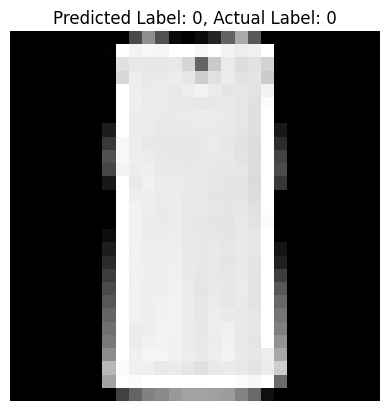

In [ ]:
model_key = ("['Conv2D', 'MaxPooling2D', 'Flatten', 'Dense', 'Dense']", 'rmsprop', '0.0005', 'N/A', '1e-05')
model = trained_models.get(model_key)

image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    # Convolutional layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    # MaxPooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten layer
    layers.Flatten(),
    # Dense layer with 128 units
    layers.Dense(units=128, activation='relu'),
    # Output Dense layer with 10 units (for the 10 classes)
    layers.Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=25)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/25
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4001 - accuracy: 0.8578
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2670 - accuracy: 0.9034
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2267 - accuracy: 0.9172
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1994 - accuracy: 0.9272
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1793 - accuracy: 0.9354
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1620 - accuracy: 0.9413
Epoch 7/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1467 - accuracy: 0.9465
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1343 - accuracy: 0.9522
Epoch 9/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1247 - accuracy: 0.9555
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.115

#Graphs

In [ ]:
import pandas as pd
import seaborn as sns

results_2nd_path = 'experiment_results_2nd.csv'
results_cnns_path = 'experiment_results_CNNs.csv'

# Read the CSV files into DataFrames
results_2nd = pd.read_csv(results_2nd_path)
results_cnns = pd.read_csv(results_cnns_path)

# Convert Accuracy in 'experiment_results_2nd' from percentage string to decimal
results_2nd['Accuracy'] = results_2nd['Accuracy'].str.rstrip('%').astype('float') / 100

results_2nd.rename(columns={'Accuracy': 'Test Accuracy'}, inplace=True)

# Consolidate the data by keeping relevant columns
results_2nd_simplified = results_2nd[['Layer Configuration', 'Optimizer', 'Test Accuracy']]
results_cnns_simplified = results_cnns[['Layer Configuration', 'Optimizer', 'Test Accuracy']]

# Combine both datasets for plotting
combined_results = pd.concat([results_2nd_simplified.assign(Experiment='Part 1'),
                              results_cnns_simplified.assign(Experiment='Part 2')],
                             ignore_index=True)

combined_results.head()




,Layer Configuration,Optimizer,Test Accuracy,Experiment
0,"[92, 36]",SGD,0.8510,Part 1
1,"[92, 36]",SGD,0.8815,Part 1
2,"[92, 36]",SGD,0.8802,Part 1
3,"[92, 36]",SGD,0.8857,Part 1
4,"[92, 36]",Adam,0.8822,Part 1


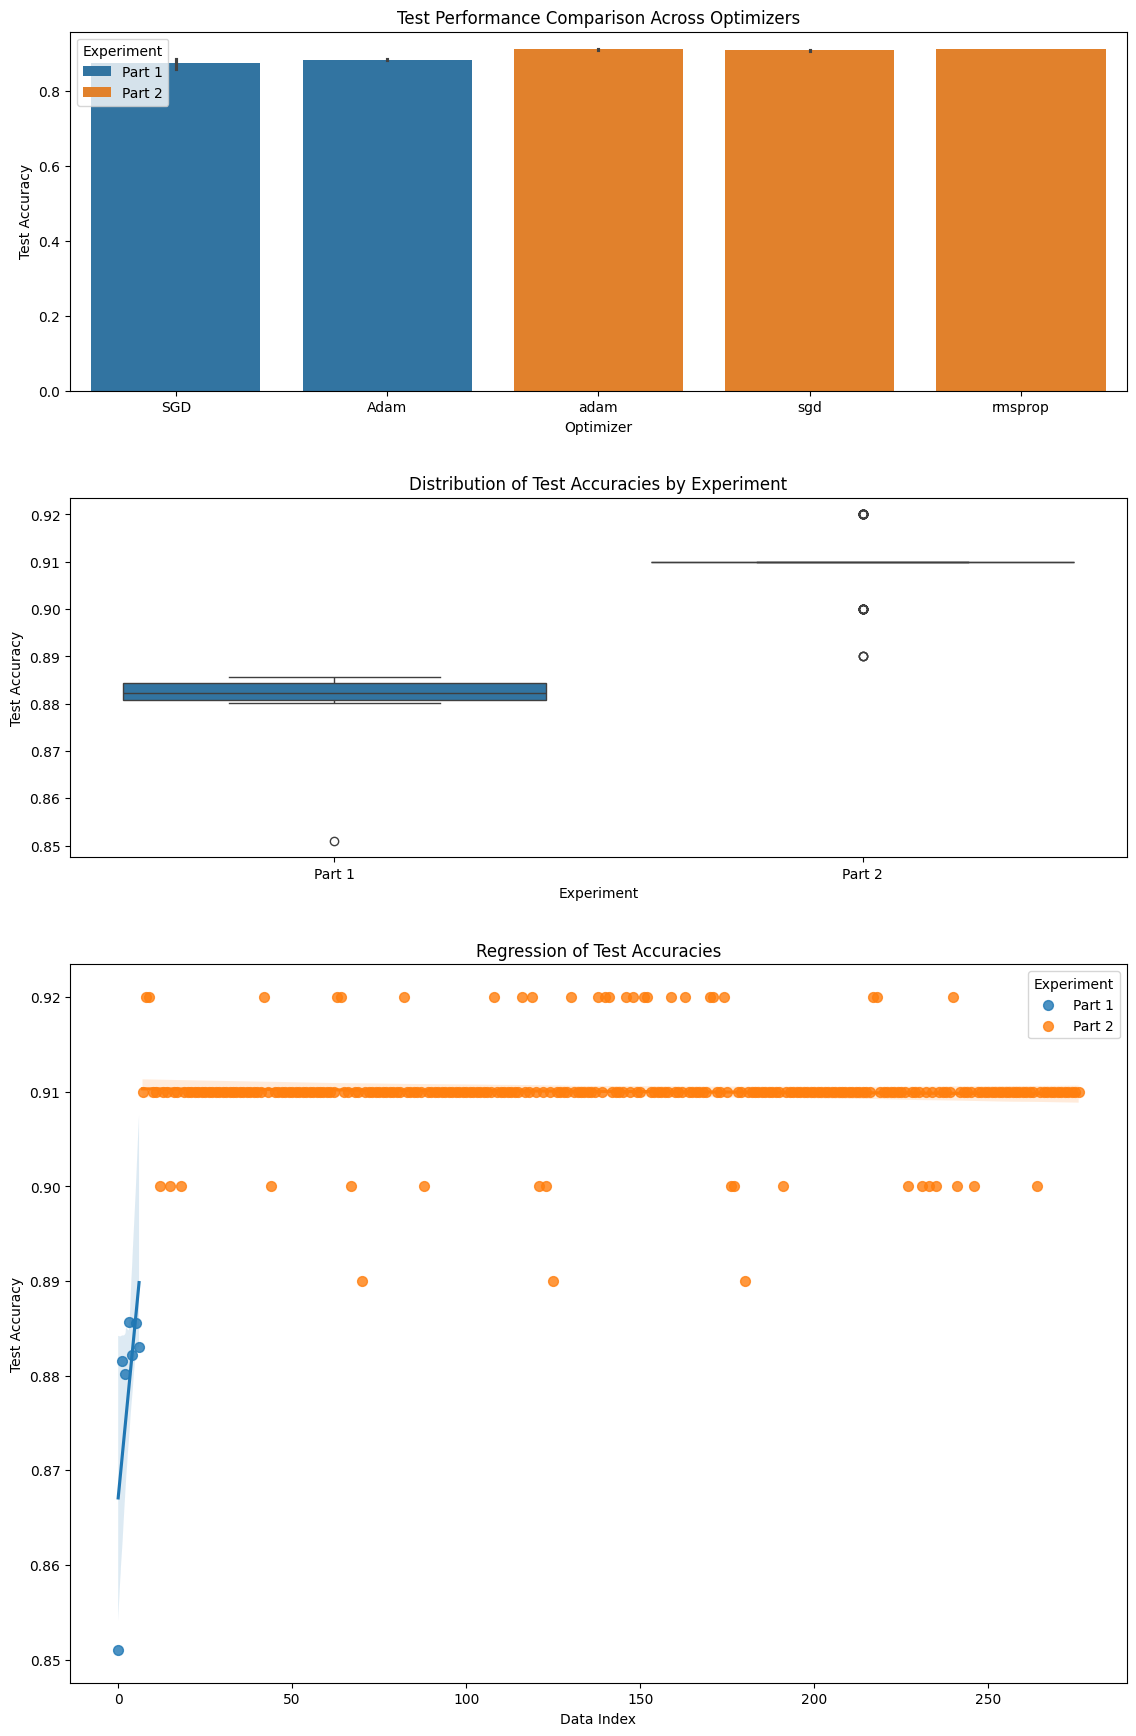

In [ ]:
# Set up the matplotlib figure for a combined layout
fig, ax = plt.subplots(3, 1, figsize=(12, 18), gridspec_kw={'height_ratios': [1, 1, 2]})

# Bar plot for comparing test accuracies
sns.barplot(ax=ax[0], data=combined_results, x='Optimizer', y='Test Accuracy', hue='Experiment')
ax[0].set_title('Test Performance Comparison Across Optimizers')
ax[0].set_xlabel('Optimizer')
ax[0].set_ylabel('Test Accuracy')
ax[0].legend(title='Experiment', loc='upper left')

# Box plot for visualizing distribution of accuracies
sns.boxplot(ax=ax[1], data=combined_results, x='Experiment', y='Test Accuracy')
ax[1].set_title('Distribution of Test Accuracies by Experiment')
ax[1].set_xlabel('Experiment')
ax[1].set_ylabel('Test Accuracy')

# Scatter plot with regression line for trends
sns.regplot(ax=ax[2], data=combined_results[combined_results['Experiment'] == 'Part 1'],
            x=combined_results.index[combined_results['Experiment'] == 'Part 1'], y='Test Accuracy',
            label='Part 1', scatter_kws={'s': 50})
sns.regplot(ax=ax[2], data=combined_results[combined_results['Experiment'] == 'Part 2'],
            x=combined_results.index[combined_results['Experiment'] == 'Part 2'], y='Test Accuracy',
            label='Part 2', scatter_kws={'s': 50})

ax[2].set_title('Regression of Test Accuracies')
ax[2].set_xlabel('Data Index')
ax[2].set_ylabel('Test Accuracy')
ax[2].legend(title='Experiment')

plt.tight_layout(pad=3.0)
plt.show()


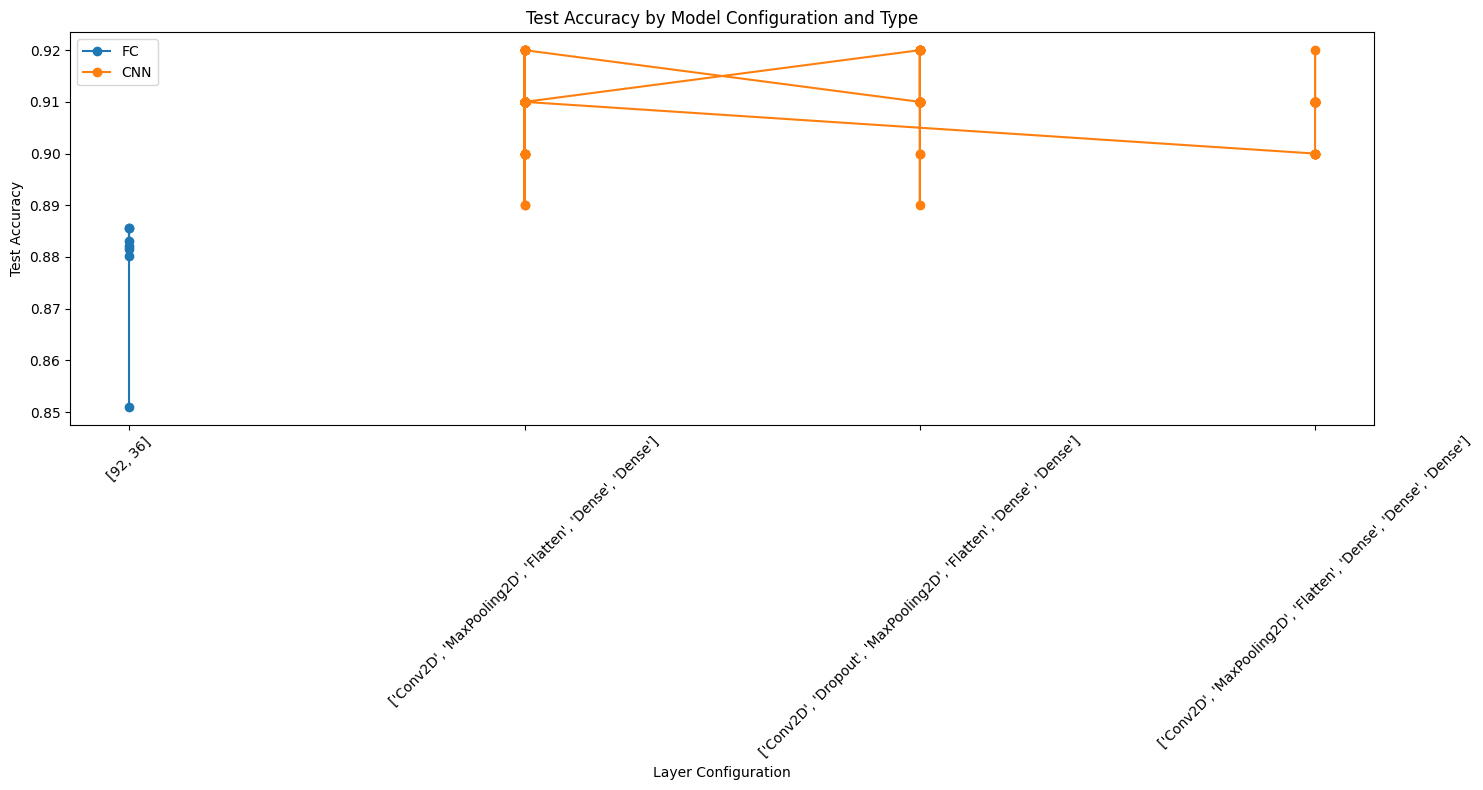

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fc_results = pd.read_csv('experiment_results_2nd.csv')
cnn_results = pd.read_csv('experiment_results_CNNs.csv')

# Convert accuracy percentages in FC results to a decimal format
fc_results['Test Accuracy'] = fc_results['Accuracy'].str.rstrip('%').astype('float') / 100

# Adjust the CNN results to match the column name
cnn_results.rename(columns={'Test Accuracy': 'Test Accuracy', 'Val Accuracy': 'Val Accuracy'}, inplace=True)

# Combine the results, ensuring all columns match and add a column to distinguish between FC and CNN
combined_results = pd.concat([fc_results, cnn_results], ignore_index=True)
combined_results['Model Type'] = ['FC'] * len(fc_results) + ['CNN'] * len(cnn_results)

# Plotting the test accuracies
plt.figure(figsize=(15, 8))
for model_type in combined_results['Model Type'].unique():
    subset = combined_results[combined_results['Model Type'] == model_type]
    plt.plot(subset['Layer Configuration'], subset['Test Accuracy'], label=model_type, marker='o')

plt.xlabel('Layer Configuration')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Model Configuration and Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams